### Bo's Dataset and Intersection Volume 2022-02
This file loads Bo's dataset/shapefile for cycling stress classification:<br>
(https://github.com/lin-bo/Toronto_LTS_network) <br>
Based off of the full Toronto Centreline dataset: <br> 
(found at https://ckan0.cf.opendata.inter.prod-toronto.ca/ne/dataset/toronto-centreline-tcl) <br>
It also loads in traffic volumes at intersections taken from Toronto's Open Data Portal: <br>
(https://open.toronto.ca/dataset/traffic-signal-vehicle-and-pedestrian-volumes/)

Work performed:
- load data
- perform eda in combination with traffic counts. Combine datasets using geospatial joins.
- store in geopandas df and create some plots for EDA. Look at the trends over time

#### Imports:

In [52]:
# Import 3rd party libraries
import os
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt

# Configure Notebook
%matplotlib inline
plt.style.use('dark_background')
#plt.style.use('ggplot')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

#### Import the raw data into a dataframe
data is in the raw data project folder. Includes intersections data, shapefile, and Bo's classifications

In [9]:
# Import the intersection data
intersections = pd.read_csv('C:/Users/keaga/PycharmProjects/1498-ML-Project/data/raw_data/traffic-signal-vehicle-and-pedestrian-volumes-data.csv')
print(intersections.info())
intersections.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2280 entries, 0 to 2279
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   TCS #                        2280 non-null   int64  
 1    Main                        2280 non-null   object 
 2    Midblock Route              175 non-null    object 
 3    Side 1 Route                2280 non-null   object 
 4    Side 2 Route                758 non-null    object 
 5   Activation Date              2280 non-null   object 
 6   Latitude                     2280 non-null   float64
 7   Longitude                    2280 non-null   float64
 8   Count Date                   2280 non-null   object 
 9   8 Peak Hr Vehicle Volume     2280 non-null   int64  
 10  8 Peak Hr Pedestrian Volume  2280 non-null   int64  
dtypes: float64(2), int64(3), object(6)
memory usage: 196.1+ KB
None


,TCS #,Main,Midblock Route,Side 1 Route,Side 2 Route,Activation Date,Latitude,Longitude,Count Date,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume
0,2,JARVIS ST,NaN,FRONT ST E,NaN,11/15/1948,43.649418,-79.371446,06-21-2017,15662,13535
1,3,KING ST E,NaN,JARVIS ST,NaN,08/23/1950,43.650461,-79.371924,09-17-2016,12960,7333
2,4,JARVIS ST,NaN,ADELAIDE ST E,NaN,09/12/1958,43.651534,-79.372360,11-08-2016,17770,7083
3,5,JARVIS ST,NaN,RICHMOND ST E,NaN,04/21/1962,43.652718,-79.372824,12-08-2015,19678,4369
4,6,JARVIS ST,NaN,QUEEN ST E,NaN,08/24/1928,43.653704,-79.373238,09-17-2016,14487,3368


In [20]:
#import the shapefile and cut uneeded lines (see code in eda_toronto_cetrelines)
geojsonpath = 'C:/Users/keaga/PycharmProjects/1498-ML-Project/data/raw_data/centreline_wgs84_geojson_v2/CENTRELINE_WGS84.geojson'
centrelines_gpd = gpd.read_file(geojsonpath)

cycle_features = ['Local', 'Major Arterial', 'Collector',
                'Laneway',
                'Minor Arterial','Expressway', 'Expressway Ramp',
                'Major Arterial Ramp',
                'Trail',
                'Other Ramp','Collector Ramp',
                'Minor Arterial Ramp','Access Road']

centrelines_cycling_gpd = centrelines_gpd[centrelines_gpd['FEATURE_CODE_DESC'].isin(cycle_features)]

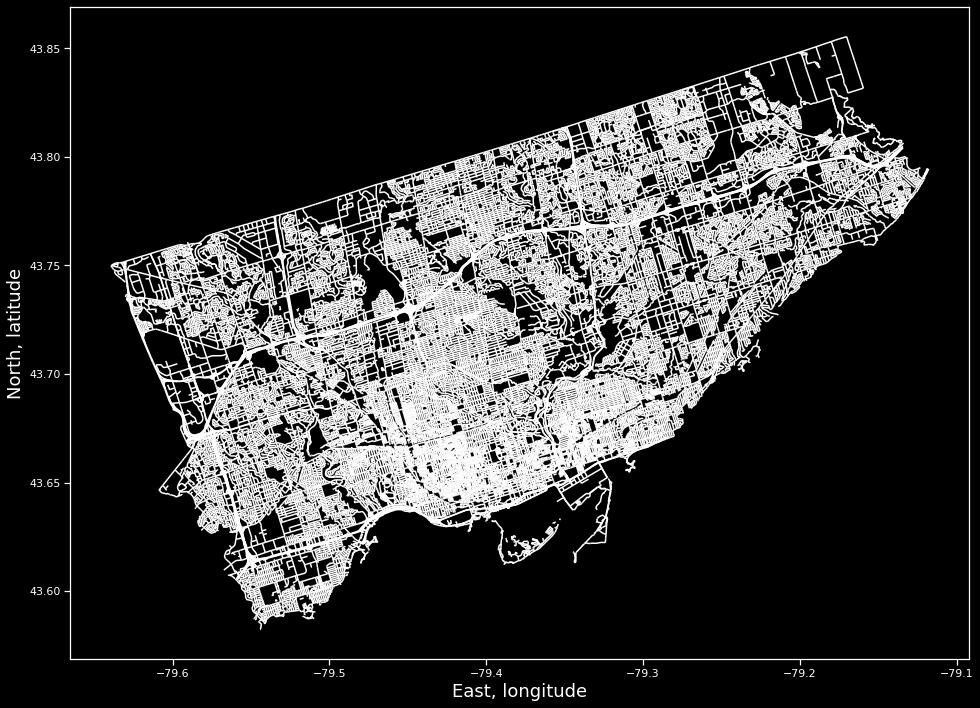

In [22]:
#plot the shapefile to view.
ax = centrelines_cycling_gpd.plot(figsize=(20, 12))
plt.xlabel('East, longitude', fontsize=18)
plt.ylabel('North, latitude', fontsize=18)
ax.grid(False)

In [25]:
#convert to pandas dataframe using lat long and plot
intersections_gpd = gpd.GeoDataFrame(intersections, geometry=gpd.points_from_xy(intersections.Longitude, intersections.Latitude))

#View Frame
intersections_gpd.head()
intersections_gpd.iloc[2261]

TCS #                                                    2377
 Main                                               YONGE ST 
 Midblock Route                                           NaN
 Side 1 Route                                  YORKVILLE AVE 
 Side 2 Route                                             NaN
Activation Date                                    04-20-2016
Latitude                                            43.671923
Longitude                                          -73.389642
Count Date                                         01-18-2017
8 Peak Hr Vehicle Volume                                 7803
8 Peak Hr Pedestrian Volume                              5014
geometry                       POINT (-73.3896419 43.6719226)
Name: 2261, dtype: object

,TCS #,Main,Midblock Route,Side 1 Route,Side 2 Route,Activation Date,Latitude,Longitude,Count Date,8 Peak Hr Vehicle Volume,8 Peak Hr Pedestrian Volume,geometry
2228,2312,STEELES AVE W,NaN,ALBION RD,REGIONAL RD 50,08/01/2012,43.749850,-79.639290,05-15-2015,29577,19,POINT (-79.63929 43.74985)
2023,2072,ALBION RD,NaN,CODLIN CRES,CLAIREPORT CRES,06/21/2006,43.747780,-79.632450,05-24-2016,11876,81,POINT (-79.63245 43.74778)
1992,2037,ALBION RD,NaN,STEINWAY BLVD,PRIVATE ACCESS,01/10/2006,43.748050,-79.628760,05-24-2016,13276,102,POINT (-79.62876 43.74805)
1944,1980,STEELES AVE W,NaN,SIGNAL HILL AVE,PRIVATE ACCESS,10/08/2003,43.753060,-79.625110,05-15-2015,16258,305,POINT (-79.62511 43.75306)
2098,2154,HUMBERWOOD BLVD,NaN,MORNING STAR DR,NaN,06/11/2008,43.726157,-79.622225,10-05-2009,7890,374,POINT (-79.62223 43.72616)
...,...,...,...,...,...,...,...,...,...,...,...,...
1875,1901,PORT UNION RD,NaN,CONFERENCE BLVD,NaN,08/21/2001,43.786142,-79.139429,08-08-2016,7603,211,POINT (-79.13943 43.78614)
2110,2167,PORT UNION RD,NaN,ADENMORE RD,CLAPPISON BLVD,08/28/2008,43.781342,-79.137631,01-25-2010,6168,293,POINT (-79.13763 43.78134)
1568,1574,LAWRENCE AVE E,NaN,PORT UNION RD,NaN,04/05/1989,43.779630,-79.136690,05-19-2016,8095,519,POINT (-79.13669 43.77963)
1819,1838,LAWRENCE AVE E,NaN,EAST AVE,PRIVATE ACCESS,08/16/1999,43.780720,-79.131590,01-25-2018,3522,1394,POINT (-79.13159 43.78072)


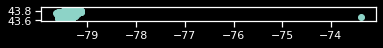

In [24]:
#There is an outlier longitude value in the geometry.
intersections_gpd.plot()

#Sort by ascending.
intersections.sort_values(by='Longitude', ascending=True)

<AxesSubplot:>

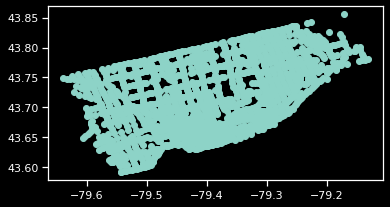

In [26]:
#The extreneous value is a young street. -73 might be an improper input of -79. Remove it for now and plot
intersections_gpd = intersections_gpd.drop(index=2261)
intersections_gpd.plot()

In [45]:
#import Bo's shapefile
lts_gpd = gpd.read_file('C:/Users/keaga/PycharmProjects/1498-ML-Project/data/raw_data/Bo Github Data/centerline_LTS_July2021.shp')

#View 
print(lts_gpd.crs)
print(lts_gpd.info())
lts_gpd.head()

epsg:4326
<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 59554 entries, 0 to 59553
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   OBJECTID    59554 non-null  int64   
 1   GEO_ID      59554 non-null  int64   
 2   LFN_ID      59554 non-null  int64   
 3   LF_NAME     59554 non-null  object  
 4   FNODE       59554 non-null  int64   
 5   TNODE       59554 non-null  int64   
 6   ONE_WAY_DI  59554 non-null  int64   
 7   length_in_  59554 non-null  float64 
 8   GEO_ID_1    59554 non-null  int64   
 9   LTS         59554 non-null  int64   
 10  Shape_Leng  59554 non-null  float64 
 11  geometry    59554 non-null  geometry
dtypes: float64(2), geometry(1), int64(8), object(1)
memory usage: 5.5+ MB
None


,OBJECTID,GEO_ID,LFN_ID,LF_NAME,FNODE,TNODE,ONE_WAY_DI,length_in_,GEO_ID_1,LTS,Shape_Leng,geometry
0,1,30079678,19155,Waterfront Trl,30079676,30079656,0,457.224811,30079678,1,0.004459,"LINESTRING (-79.54478 43.58583, -79.54478 43.5..."
1,2,30079680,19166,Marie Curtis Park Trl,30079676,30079679,0,35.226524,30079680,1,0.000426,"LINESTRING (-79.54478 43.58583, -79.54483 43.5..."
2,3,30079677,19155,Waterfront Trl,30008708,30079676,0,37.170074,30079677,1,0.000375,"LINESTRING (-79.54454 43.58611, -79.54464 43.5..."
3,4,30082310,10685,Island Rd,30008708,30082309,0,168.541328,30082310,1,0.001771,"LINESTRING (-79.54454 43.58611, -79.54433 43.5..."
4,5,30008940,19155,Waterfront Trl,30008711,30008708,0,84.289210,30008940,1,0.000892,"LINESTRING (-79.54386 43.58668, -79.54400 43.5..."


<AxesSubplot:>

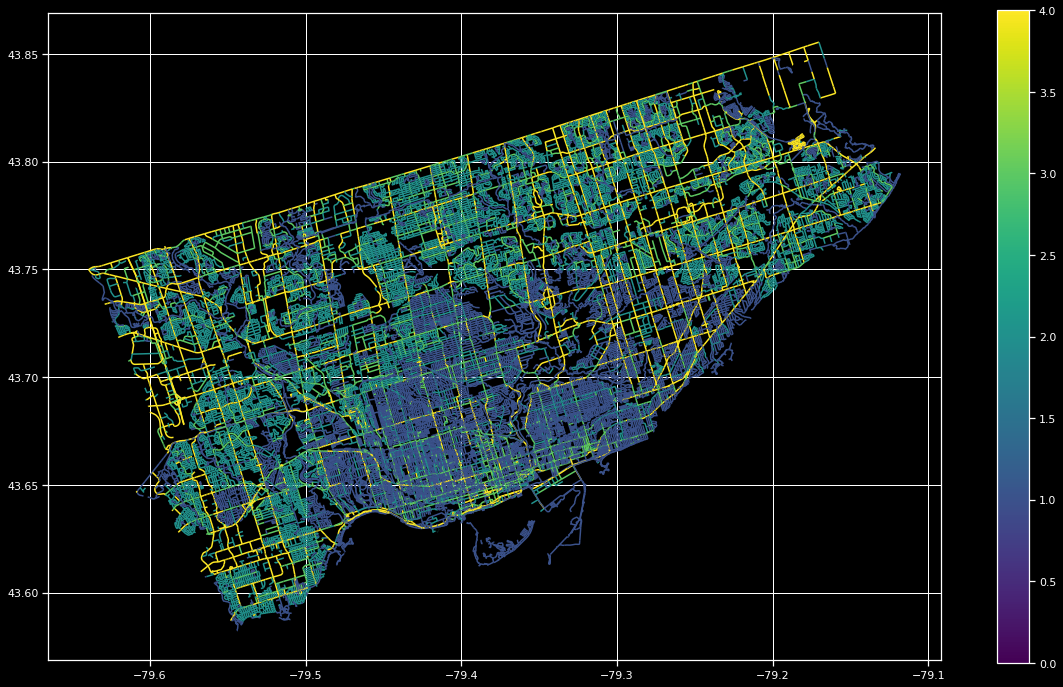

In [53]:
lts_gpd.plot(column='LTS',figsize=(20, 12), legend=True)

#### EDA: plot the intersections together with shapes and Bo's data, look at different features
lots of plotting

In [32]:
#convert to the same CRS. The Shapefile has CRS epsg:4326
intersections_gpd.crs = {'init': 'epsg:4326'}
#for later work we can use EPSG:26917 if we want to measure distances.

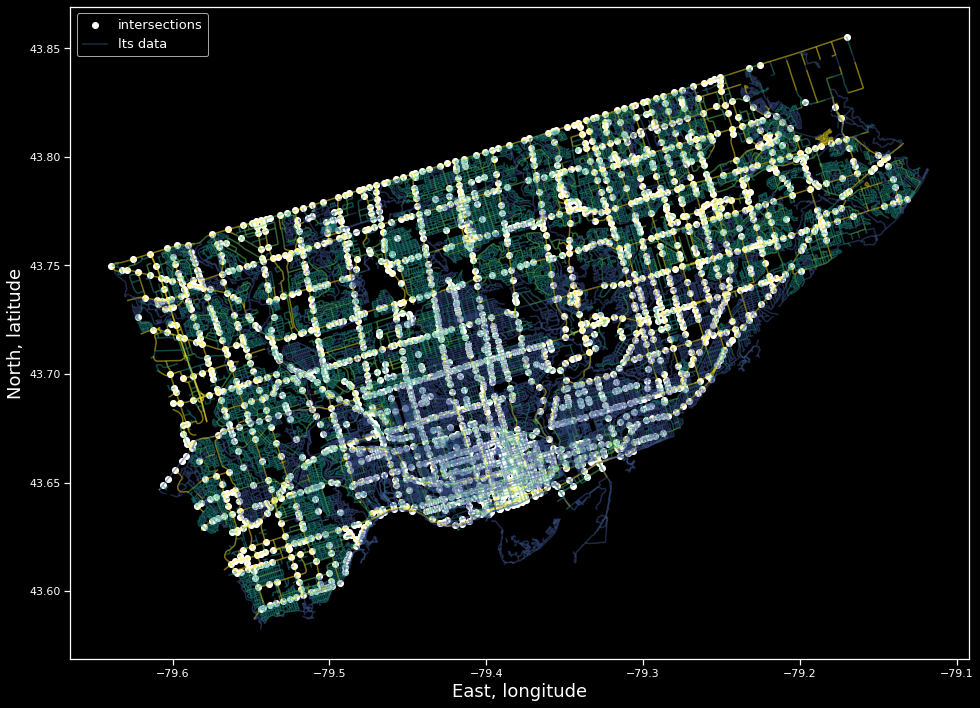

In [49]:
#Plot the two against each other. Either Bo's or the overall shapefile
ax = intersections_gpd.plot(figsize=(20, 12), label='intersections', color='white')
lts_gpd.plot(ax=ax, column='LTS', figsize=(20, 12), label='lts data', alpha=0.5)
#centrelines_cycling_gpd.plot(ax=ax, alpha=0.5, label='cycleable roads')
plt.xlabel('East, longitude', fontsize=18)
plt.ylabel('North, latitude', fontsize=18)
ax.grid(False)
plt.legend(prop={'size':13})

In [ ]:
# Next look at the mix of different roads and LTS